# Behavioral Cloninig Project

---

## Training a model with Keras

In [17]:
# import tensorflow as tf
# import numpy as np
# import cv2
# import os
# from tensorflow.contrib.layers import flatten
# from sklearn.utils import shuffle
# from tabulate import tabulate
# import itertools
# import pickle
# import math
# import time
# import csv

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

## Pre Processing

## Training Pipeline

In [15]:
import tensorflow as tf
import csv
import matplotlib.image as mpimg
import numpy as np

data_files_path_origin = 'data/'
data_files_path_running = 'data/'
steering_correction = 0.2

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
steering_correction_arr = [0.0, steering_correction, -1.0*steering_correction]

for line in lines:
    for i in range(len(steering_correction_arr)):
        if data_files_path_origin != data_files_path_running:
            source_path = line[i]
            filename = source_path.split('/')[-1]
            current_path = data_files_path_running + 'IMG/' + filename
        else:
            current_path = line[i]

        image = mpimg.imread(current_path)
        images.append(image)
        measurement = float(line[3]) + steering_correction_arr[i]
        measurements.append(measurement)

augmented_images = []
augmented_measurements = []

for image,measurement in zip(images,measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

print("Size of training dataset \t= {}\tshape = {}\tdtype:{}".format(len(X_train),X_train[0].shape,X_train.dtype))

Size of training dataset 	= 17100	shape = (160, 320, 3)	dtype:uint8


In [16]:
# Training params
validation_split = 0.2
epoch = 4

In [18]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Activation, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()
model.add(Lambda(lambda x: x/ 255.0 -0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(36,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(48,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
# model.add(MaxPooling2D())
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object= model.fit(X_train,y_train, validation_split=validation_split, shuffle=True, epochs=epoch, verbose=1)

model.save('model.h5')

ipykernel_launcher:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
ipykernel_launcher:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
ipykernel_launcher:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
ipykernel_launcher:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
ipykernel_launcher:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
ipykernel_launcher:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
Train on 13680 samples, validate on 3420 samples
Epoch 1/4
13680/13680 [==============================] - 62s 5ms/step - loss: 0.0300 - val_loss: 0.0446
Epoch 2/4
13680/13680 [==============================] - 61s 4ms/step - loss: 0.0254 - val_lo

In [19]:
### print the keys contained in the history object
print(history_object.history.keys())

dict_keys(['loss', 'val_loss'])


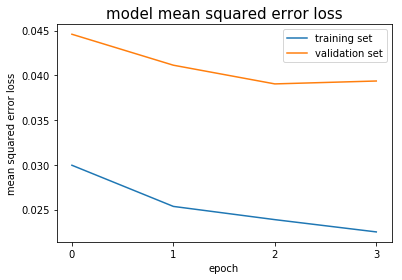

In [28]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss', fontsize=15)
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history_object.history['loss'])))
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig("training_mse.png")
plt.show()


## Train model using generator

In [ ]:
import os
import csv

samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(ch, row, col),
        output_shape=(ch, row, col)))
model.add(... finish defining the rest of your model architecture here ...)

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, /
            steps_per_epoch=ceil(len(train_samples)/batch_size), /
            validation_data=validation_generator, /
            validation_steps=ceil(len(validation_samples)/batch_size), /
            epochs=5, verbose=1)